# Neuron simulator tutorial

Contributors: Elisabetta Iavarone, Werner Van Geit, Bruno Magalhaes, Francesco Cremonesi @ Blue Brain Project, EPFL, Switzerland

NEURON was original developed with a scripting language called "hoc". It is still widely used and only recently it is being replaced with a Python interface [(Hines et al., 2009)](http://journal.frontiersin.org/article/10.3389/neuro.11.001.2009/abstract). All NEURON routines are written in either C/C++ or hoc.
NEURON features also a Graphical User Interface (GUI), equipped with builders for cells and networks, channels and electrical circuits. Feel free to explore the NEURON GUI, but here we prefer writing some lines of Python code.
___
In this tutorial we will see how to use a small number of NEURON functions, while you can find further information on NEURON modeling concepts and programming-related terms in the [programmer's reference](http://www.neuron.yale.edu/neuron/static/new_doc/index.html).
____

First we need **import** the Neuron simulator in Python.

In [1]:
import neuron

This will give us the ability to interact with the simulator. Most of the code we use will access the Neuron **HocObject**, accessible through *neuron.h*

For example, to get the **temperature** the simulation will be performed in:

In [2]:
print 'Temperature: %g C, Time: %g ms' % (neuron.h.celsius, neuron.h.t)

Temperature: 6.3 C, Time: 0 ms


As you can see, the **default temperature** the Neuron simulator is running in is **6.3C**. 
This is the temperature in which Hodgkin and Huxley performed their original voltage clamp experiments.

(So always remember to set the simulator to the correct temperature when building your own model !)

## Creating a single section

In NEURON a cell is represented as a tree of connected **sections** (cylinders). A section is a portion of cell with homogeneous biophysical properties. 
In the simplest approximation, a section is a cilinder with some properties: lengh *L* (in ${\mu}m$), diameter *diam* (in ${\mu}m$), cytoplasmic resistance *Ra* (in $ohm*cm$), membrane capacity (in ${\mu}F/cm^2$), channels density.
A **segment** (or compartment), *seg*, is the simplest unit of discretization of a section. It is a numerical entity, that defines the spatial discretizion ${\delta}x = L / nseg$.

The voltage in every compartment is calculated by integrating the following equation:

$C_{m} dV/dt = I_{membrane} + I_{external} + I_{axial}$

Let's a section to represent the soma:

In [3]:
soma = neuron.h.Section(name='soma')
print soma

*soma* is now a python object that as certain fields attached to it:

In [4]:
dir(soma)

['L',
 'Ra',
 '__call__',
 '__class__',
 '__delattr__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allseg',
 'cell',
 'children',
 'connect',
 'hname',
 'hoc_internal_name',
 'insert',
 'name',
 'nseg',
 'orientation',
 'parentseg',
 'push',
 'rallbranch',
 'same',
 'trueparentseg']

For example we can look at the length and diameter of the section, the membrane voltage and the specific capacitance:

In [5]:
print 'length: %f' % soma.L # in micron
print 'diameter: %f' %soma.diam # in micron
print 'membrane voltage: %f' % soma.v # in mV
print 'specific capacitance: %f' % soma.cm # uf/cm2

length: 100.000000
diameter: 500.000000
membrane voltage: -65.000000
specific capacitance: 1.000000


Let's change the diameter and length of the soma to 20 micron.

In [6]:
soma.L = 20
soma.diam = 20
print 'New soma diameter %f and length %f' % (soma.L, soma.diam)

New soma diameter 20.000000 and length 20.000000


## Running a simulation

Now that we have a soma section, we can run a quick simulation for 1000 ms.

In [7]:
neuron.h.load_file('stdrun.hoc')
def run_model(total_time):
    neuron.h.tstop = total_time
    neuron.h.stdinit()
    print 'Time: %f, Soma voltage: %f' % (neuron.h.t, soma.v)
    neuron.h.run()
    print 'Time: %f, Soma voltage: %f' % (neuron.h.t, soma.v)
run_model(1000)

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -65.000000


Obviously the membrane voltage in the soma didn't change. 
This is because at the moment the soma consists of an empty sphere with just a capacitance.

## Attaching a recording electrode

To make it easier to visualize the membrane voltage evolution during a simulation, we record variables into vectors.
Let's record the time, and membrane voltage in the middle of the soma.

In [8]:
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(0.5)._ref_v)
run_model(1000)

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -65.000000


Now these vectors can be plotted using matplotlib. Let's define a method we can reuse later.

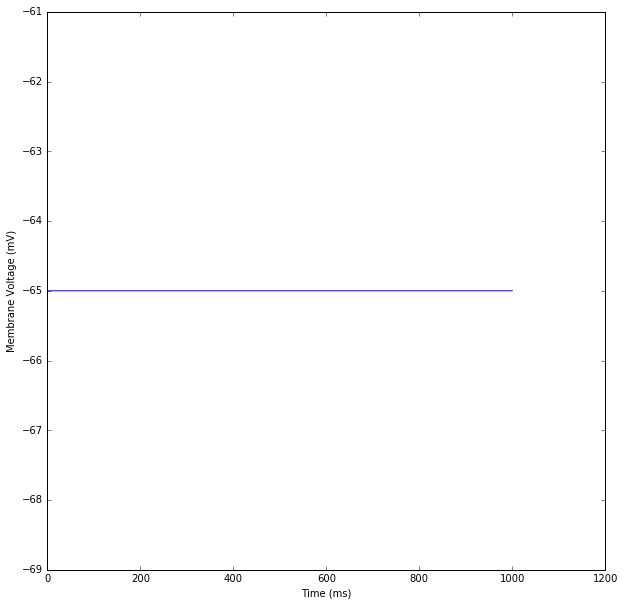

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_timevoltage(time, voltage):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(time, voltage)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane Voltage (mV)')

plot_timevoltage(time, voltage)

## Attaching a stimulus electrode

Let's make this simulation more interesting by adding a stimulus. 
A stimulation electrode in NEURON is a "point process", i.e. an object attached to a precise location along a section. The location is specified as a number from 0 to 1.
To set up a current clamp experiment we need to specify its location, *delay* (time from the start of the simulation), *amp* (amplitude of the injected current, in *nA*) and *dur* (duration of stimulus in *ms*).

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -33.169011


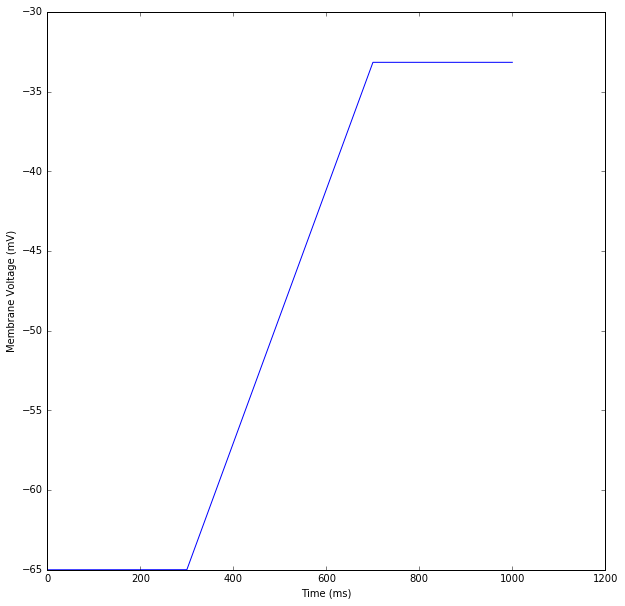

In [10]:
# Inject a current step into the soma
stim = neuron.h.IClamp(0.5, sec=soma) # Place a stimulation electrode in the middle of the soma
stim.delay = 300 # ms
stim.amp = 0.001 # nA
stim.dur = 400 # ms
run_model(1000)
plot_timevoltage(time, voltage)

## Inserting mechanisms (ion channels)

Mechanisms represent ion channels, buffers, synapses dynamics in NEURON. They are not point processes but "distributed mechanisms" and they are present on the entire surface of a section. Mechanisms parameters can change within compartments.
NEURON has some built-in mechanisms, for example a passive leak current *pas* and sodium and potassium currents to generate action potentials *hh* (from the squid axon, measured by Hodgkin and Huxley!)

At the moment this soma section still acts as a capacitance. 
We can now add some ion channels to the membrane.
Let's start with a passive leak channel.
The way we set it up it will have a reversal potential of -70 mV, which means the leak channel will 'drive' the membrane voltage towards -70 mV.

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -69.610694


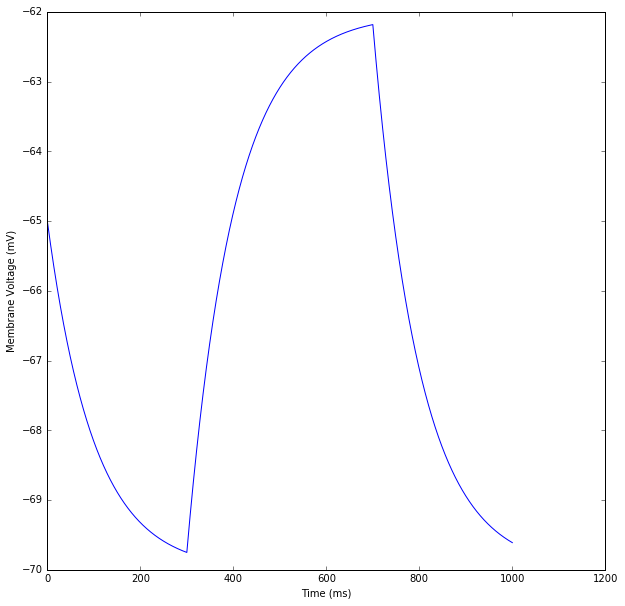

In [11]:
soma.insert('pas')
soma.g_pas = 1e-5 # nS/cm2
soma.e_pas = -70 # mV
run_model(1000)
plot_timevoltage(time, voltage)

Neuron contains a default Hodgkin-Huxley 'hh' mechanism. We can add this to the soma, so that we can generate some spikes.

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -74.633379


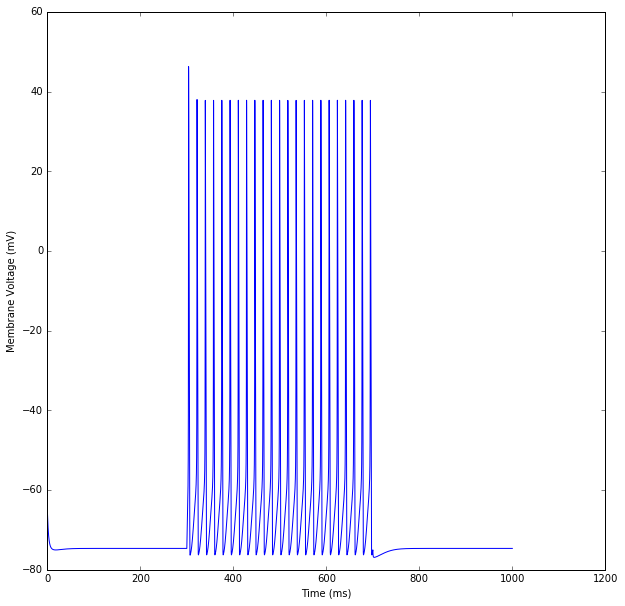

In [12]:
soma.insert('hh')
soma.gl_hh = 0.0 # Disabling passive channel inside hh mechanism
stim.amp = 0.07 # nA
run_model(1000)
plot_timevoltage(time, voltage)

__Exercise__: Try to change the model, stimulus or simulation parameters so that you only get e.g. 5 spikes.

__Exercise__: Which parameters influence the shape of the action potential ? Try to decrease the amplitude of the spikes.

## Connecting sections

The first step to make this cell more realistic, is to add a dendrite. We create a new section, and connect it to the soma.

In [13]:
dend = neuron.h.Section(name='dend')
dend.L = 500
dend.diam = 1
dend.connect(soma);
help(dend.connect)

Enabling NEURON+Python help system.
Help on built-in function connect:

connect(...)
    childSection.connect(parentSection, [parentX], [childEnd]) or
    childSection.connect(parentSegment, [childEnd])



To make sure everything is connected correctly, we print the names of the child sections of the soma

In [14]:
for child in soma.children():
    print neuron.h.secname(sec=child)

dend


We add a recording electrode to the dendrite, and add a new plotting functions that allows us to plot a list of traces.

In [15]:
time_dend = neuron.h.Vector()
voltage_dend = neuron.h.Vector()

time_dend.record(neuron.h._ref_t)
voltage_dend.record(dend(1.0)._ref_v) # record at end of dendrite (location=0.1)

def plot_timevoltages(timevoltages):
    fig, ax = plt.subplots(figsize=(10,10))
    for time, voltage in timevoltages:
        ax.plot(time, voltage)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Membrane Voltage (mV)')

Now we can run the two compartmental model

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -74.632996


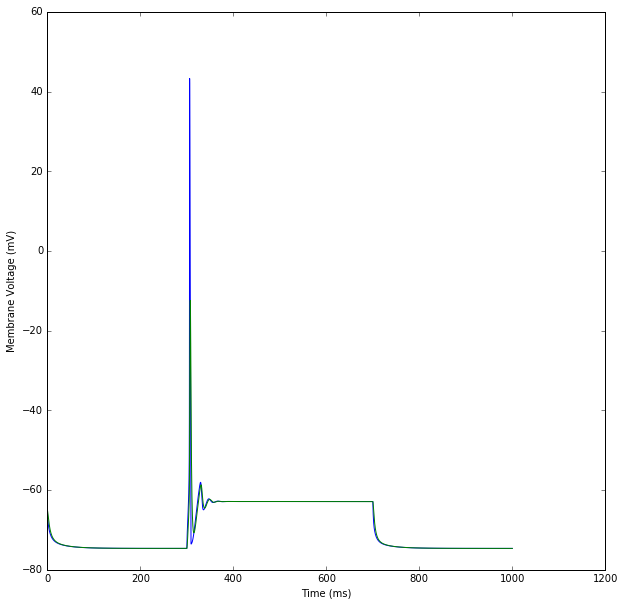

In [16]:
stim.amp = 0.07
run_model(1000)
plot_timevoltages([(time, voltage), (time_dend, voltage_dend)])

__Exercise__: After we connected the extra compartment, the response changed. We didn't add any mechanisms to the dendritic compartment, what happened ?

__Exercise__: Add a passive mechanism to the dendrite. Try again to get 5 spikes in the soma by changing the stimulus parameters. Can you achieve the same by only changing the parameters of the sections ?

## Adding synapses

To allow us to connect two cells, we're first going to add a synapse to dendrite of this cell.

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -74.632996


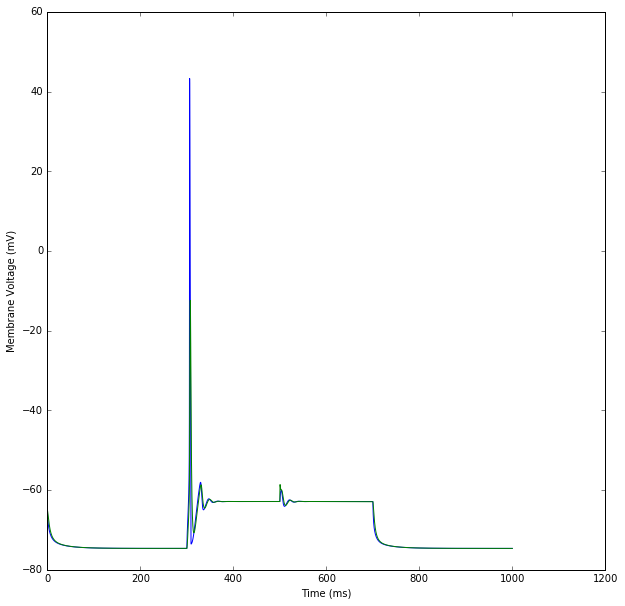

In [17]:
synapse = neuron.h.AlphaSynapse(dend(0.5))
synapse.onset = 500
synapse.gmax = .005
run_model(1000)
plot_timevoltages([(time, voltage), (time_dend, voltage_dend)])

As you can see, the synapse is activated at the onset time we set to 500 ms.

__Exercise__: Add 5 synapses with different onset, let the cell spike 5 times using synaptic input

## Connecting two cells

Let's build a small network of two cells. First we need a second cell, we'll immediately connect a recording electrode

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -74.632996


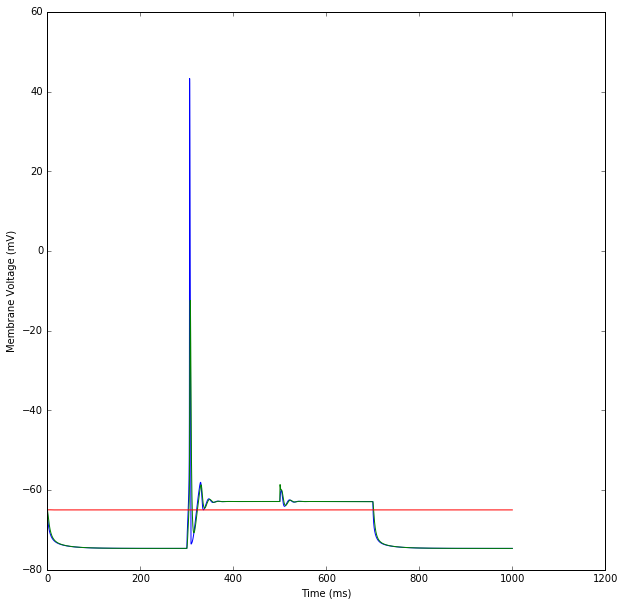

In [18]:
soma2 = neuron.h.Section(name='soma2')
soma2.L = 20
soma2.diam = 20
soma2.insert('hh')
time2 = neuron.h.Vector()
voltage2 = neuron.h.Vector()
time2.record(neuron.h._ref_t)
voltage2.record(soma2(0.5)._ref_v)
run_model(1000)
plot_timevoltages([(time, voltage), (time_dend, voltage_dend), (time2, voltage2)])

As you can see, the second soma is completely silent. Let's add a synapse and connect it with the soma of the first cell. Every time that soma will cross the threshold, a synaptic event is sent to synapse2 through a NetCon object.
This time we attach a ExpSyn, because an AlphaSynapse doesn't accept synaptic events as input.

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -74.632996


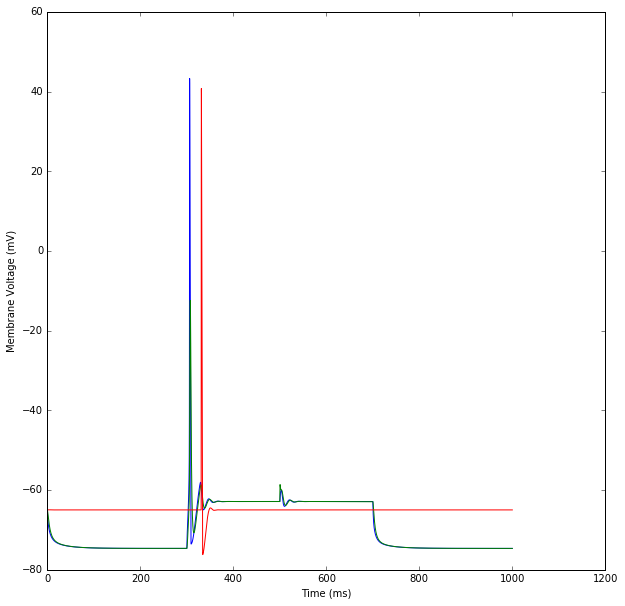

In [19]:
synapse2 = neuron.h.ExpSyn(soma2(0.5))
connection = neuron.h.NetCon(soma(0.5)._ref_v, synapse2, sec=soma)
connection.weight[0] = 1
connection.delay = 25

run_model(1000)
plot_timevoltages([(time, voltage), (time_dend, voltage_dend), (time2, voltage2)])

We can make this a recurrent connection, by also connecting soma2 to the soma of the first cell with a synapse

Time: 0.000000, Soma voltage: -65.000000
Time: 1000.000000, Soma voltage: -75.061788


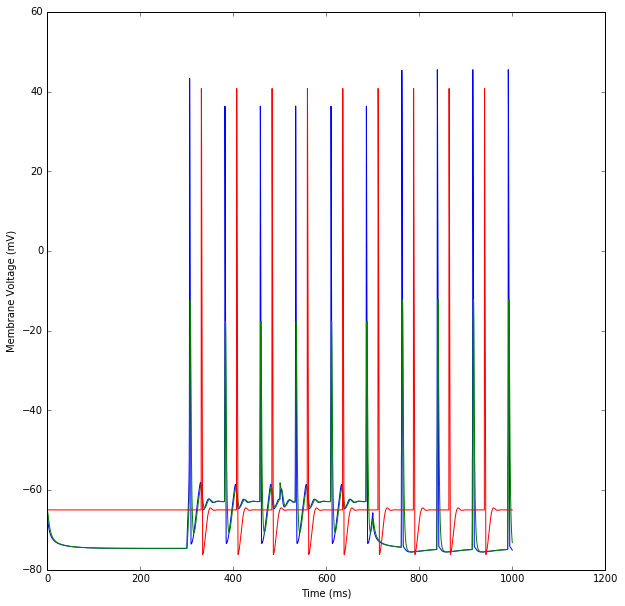

In [20]:
synapse3 = neuron.h.ExpSyn(soma(0.5))
connection2 = neuron.h.NetCon(soma2(0.5)._ref_v, synapse3, sec=soma2)
connection2.weight[0] = .05
connection2.delay = 50

run_model(1000)
plot_timevoltages([(time, voltage), (time_dend, voltage_dend), (time2, voltage2)])

__Exercise__: As you can see the two cells trigger each other, even outside of the stimulus interval. Try to find out which parameter you have to change to only have this behavior during the stimulus.

___
## Futher interesting resources about NEURON

__The NEURON forum__: 
http://www.neuron.yale.edu/phpBB/

__NEURON programmer's reference and documentation__: 
http://www.neuron.yale.edu/neuron/static/new_doc/index.html

__NEURON web page and installation instructions__:
http://www.neuron.yale.edu/neuron/

__ModelDB: database of existing NEURON models__:
https://senselab.med.yale.edu/modeldb/

__The NEURON book and other readings__:

Nicholas T. Carnevale and Michael L. Hines, "The NEURON book". Cambridge University Press, 2006

M.L. Hines and N.T. Carnevale. "Neuron simulation environment". Encyclopedia of computational neuroscience, Springer, 2014
